In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import utm
import math
from math import radians, cos, sin, asin, sqrt
from matplotlib import pyplot as plt

In [59]:
gsm_train = pd.read_csv('LTE/new4gtrain.csv')
gsm_test = pd.read_csv('LTE/new4gtest.csv')

In [60]:
gsm_train.columns

Index([u'MRTime', u'IMSI', u'SRNCID', u'BestCellID', u'SRNTI', u'RAB',
       u'Delay', u'UE_TXPower', u'LCS_BIT', u'Longitude', u'Latitude',
       u'RNCID_1', u'CellID_1', u'EcNo_1', u'RSCP_1', u'RTT_1', u'UE_Rx_Tx_1',
       u'RNCID_2', u'CellID_2', u'EcNo_2', u'RSCP_2', u'RTT_2', u'UE_Rx_Tx_2',
       u'RNCID_3', u'CellID_3', u'EcNo_3', u'RSCP_3', u'RTT_3', u'UE_Rx_Tx_3',
       u'RNCID_4', u'CellID_4', u'EcNo_4', u'RSCP_4', u'RTT_4', u'UE_Rx_Tx_4',
       u'RNCID_5', u'CellID_5', u'EcNo_5', u'RSCP_5', u'RTT_5', u'UE_Rx_Tx_5',
       u'RNCID_6', u'CellID_6', u'EcNo_6', u'RSCP_6', u'RTT_6', u'UE_Rx_Tx_6',
       u'GridID'],
      dtype='object')

In [61]:
for i in range(1, 7):
    gsm_train['RSSI_' + str(i)] = abs(gsm_train['RSCP_' + str(i)] - gsm_train['EcNo_' + str(i)])
    gsm_test['RSSI_' + str(i)] = abs(gsm_test['RSCP_' + str(i)] - gsm_test['EcNo_' + str(i)])

In [62]:
gsm = gsm_test.append(gsm_train)

In [63]:
tests = gsm.ix[:,[u'SRNCID', u'BestCellID', u'RSSI_1', u'RSSI_2', u'RSSI_3', u'RSSI_4', u'RSSI_5',u'RSSI_6']]

regressor_y = gsm[['Longitude', 'Latitude']]
classifier_y = gsm['GridID']

In [94]:
regressor_train_x, regressor_test_x, regressor_train_y, regressor_test_y = train_test_split(tests, regressor_y, test_size=0.2)
classifier_train_x, classifier_test_x, classifier_train_y, classifier_test_y = train_test_split(tests, classifier_y, test_size=0.2)

In [65]:
regressor = RandomForestRegressor(random_state=0, n_estimators=10)
classifier = RandomForestClassifier(n_estimators=10)

In [66]:
regressor.fit(regressor_train_x, regressor_train_y)
classifier.fit(classifier_train_x, classifier_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [67]:
regressor_res = regressor.predict(regressor_test_x)
classifier_res = classifier.predict(classifier_test_x)

In [68]:
regressor.score(regressor_test_x, regressor_test_y)

0.99036855921342626

In [69]:
classifier.score(classifier_test_x, classifier_test_y)

0.49160629086411028

In [73]:
min_location = utm.from_latlon(gsm['Latitude'].min(), gsm['Longitude'].min())
max_location = utm.from_latlon(gsm['Latitude'].max(),gsm['Longitude'].max())
width = max_location[1] - min_location[1]
height = max_location[0] - min_location[0]
grid_x = math.ceil(width/20)
grid_y = math.ceil(height/20)

In [76]:
def findCenter(num):
    dr = math.ceil(num/grid_x)
    dc = num % grid_y
    c_x = min_location[1] + dc * 20 - 10
    c_y = min_location[0] + dr * 20 - 10
    return [c_x, c_y]

In [77]:
c_list = []
for i in range(len(classifier_res)):
    center = findCenter(classifier_res[0])
    c_list.append(utm.to_latlon(center[1], center[0], min_location[2], min_location[3]))

In [78]:
c_list = np.array(c_list)

In [80]:
regressor_test_y.index = range(0, len(regressor_test_y))

In [82]:
regressor_res = pd.DataFrame(regressor_res,columns=['PLO','PLA'])
c_list = pd.DataFrame(c_list,columns=['PLO','PLA'])

In [83]:
reg_eval = pd.concat([regressor_test_y,regressor_res],axis=1)
cls_eval = pd.concat([regressor_test_y,c_list],axis=1)

In [87]:
def haversine(lo1, la1, lo2, la2): 
    lo1, la1, lo2, la2 = map(radians, [lo1, la1, lo2, la2])  
  

    dlon = lo2 - lo1   
    dlat = la2 - la1   
    return sqrt(dlon*dlon + dlat*dlat)

In [96]:
regressor_com = []
classifier_com = []
for i in range(0, len(reg_eval)):
    dis = haversine(reg_eval.loc[i, 'Longitude'],reg_eval.loc[i, 'Latitude'], reg_eval.loc[i, 'PLO'], reg_eval.loc[i, 'PLA'])
    regressor_com.append(dis)
    classifier_com.append(dis)

In [97]:
regressor_com.sort()
classifier_com.sort()

In [98]:
regressor_com

[1.906037239742041e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 4.039300980909601e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.260019727943208e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014351603e-08,
 5.41604014

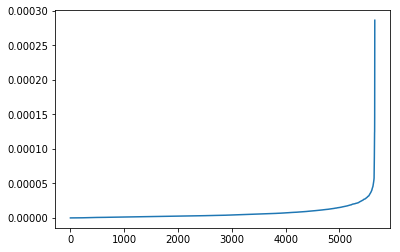

In [92]:
plt.plot(regressor_com)
plt.show()

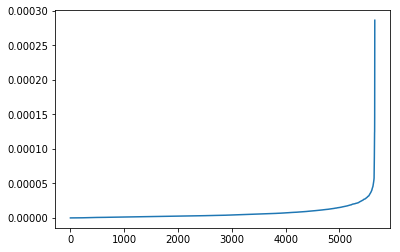

In [93]:
plt.plot(classifier_com)
plt.show()